# lab3 的缩减版

只留下最后全部数据处理所需要的必要内容

## (part0)读入文件

In [1]:
import re
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'

def removeQuotes(s):
    """ Remove quotation marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parseDatafileLine(datafileLine):
    """ Parse a line of the data file using the specified regular expression pattern
    Args:
        datafileLine (str): input string that is a line from the data file
    Returns:
        str: a string parsed using the given regular expression and without the quote characters
    """
    match = re.search(DATAFILE_PATTERN, datafileLine)
    if match is None:
        print 'Invalid datafile line: %s' % datafileLine
        return (datafileLine, -1)
    elif match.group(1) == '"id"':
        print 'Header datafile line: %s' % datafileLine
        return (datafileLine, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((removeQuotes(match.group(1)), product), 1)

### 读入数据文件

In [2]:
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('cs100', 'lab3')

GOOGLE_PATH = 'Google.csv'
GOOGLE_SMALL_PATH = 'Google_small.csv'
AMAZON_PATH = 'Amazon.csv'
AMAZON_SMALL_PATH = 'Amazon_small.csv'
GOLD_STANDARD_PATH = 'Amazon_Google_perfectMapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    """ Parse a data file
    Args:
        filename (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    """ Load a data file
    Args:
        path (str): input file name of the data file
    Returns:
        RDD: a RDD of parsed valid lines
    """
    filename = os.path.join(baseDir, inputPath, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count())
    assert failed.count() == 0
    assert raw.count() == (valid.count() + 1)
    return valid

google = loadData(GOOGLE_PATH)
amazon = loadData(AMAZON_PATH)

Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


### 读入Gold Standard文件(part of 3e)

In [17]:
GOLDFILE_PATTERN = '^(.+),(.+)'

# Parse each line of a data file useing the specified regular expression pattern
def parse_goldfile_line(goldfile_line):
    """ Parse a line from the 'golden standard' data file
    Args:
        goldfile_line: a line of data
    Returns:
        pair: ((key, 'gold', 1 if successful or else 0))
    """
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print 'Invalid goldfile line: %s' % goldfile_line
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print 'Header datafile line: %s' % goldfile_line
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = os.path.join(baseDir, inputPath, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsFailed = (gsRaw
            .filter(lambda s: s[1] == -1)
            .map(lambda s: s[0]))
for line in gsFailed.take(10):
    print 'Invalid goldfile line: %s' % line

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsFailed.count())
assert (gsFailed.count() == 0)
assert (gsRaw.count() == (goldStandard.count() + 1))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


## helper function

### (1a)Tokenize a String
the function simpleTokenize(string) that takes a string and returns a list of non-empty tokens in the string. simpleTokenize should split strings using the provided regular expression. 

In [3]:
# TODO: Replace <FILL IN> with appropriate code
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'
split_regex = r'\W+'

def simpleTokenize(string):
    """ A simple implementation of input string tokenization
    Args:
        string (str): input string
    Returns:
        list: a list of tokens
    """
    # return <FILL IN>
    return [item for item in re.split(split_regex, string.lower(), flags=re.IGNORECASE) if item not in set([''])]
    # return re.sub(split_regex, " ", string).lower().strip().split() 

print simpleTokenize(quickbrownfox) # Should give ['a', 'quick', 'brown', ... ]

['a', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


### (1b)Removing stopwords

Using the included file "stopwords.txt", implement tokenize, an improved tokenizer that does not emit stopwords.

In [4]:
# TODO: Replace <FILL IN> with appropriate code
stopfile = os.path.join(baseDir, inputPath, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
print 'These are the stopwords: %s' % stopwords

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords
    Args:
        string (str): input string
    Returns:
        list: a list of tokens without stopwords
    """
    # return <FILL IN>
    return [item for item in simpleTokenize(string) if item not in stopwords]

print tokenize(quickbrownfox) # Should give ['quick', 'brown', ... ]

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

### (2a) Implement a TF function

Implement tf(tokens) that takes a list of tokens and returns a Python dictionary mapping tokens to TF weights


In [5]:
# TODO: Replace <FILL IN> with appropriate code
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    # <FILL IN>
    dict = {}
    for t in tokens:
        if dict.has_key(t):
            dict[t] += 1.0;
        else:
            dict[t] = 1.0;
    
    count = len(tokens)
    for key in dict.keys():
        dict[key] /= count
        
    # return <FILL IN>
    return dict

print tf(tokenize(quickbrownfox)) # Should give { 'quick': 0.1666 ... }

{'brown': 0.16666666666666666, 'lazy': 0.16666666666666666, 'jumps': 0.16666666666666666, 'fox': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


### (2c) Implement an IDFs function

compute the IDF weights for all tokens in corpus

In [6]:
# TODO: Replace <FILL IN> with appropriate code
def idfs(corpus):
    """ Compute IDF
    Args:
        corpus (RDD): input corpus
    Returns:
        RDD: a RDD of (token, IDF value)
    """
    # N: the total number of documents in U
    # N = <FILL IN>
    N = corpus.count()
    
    # uniqueTokens = corpus.<FILL IN>
    uniqueTokens = corpus.flatMap(lambda doc: tf(doc[1]).keys())
    
    # tokenCountPairTuple = uniqueTokens.<FILL IN>
    tokenCountPairTuple = uniqueTokens.map(lambda t : (t, 1))
    
    # tokenSumPairTuple = tokenCountPairTuple.<FILL IN>
    tokenSumPairTuple = tokenCountPairTuple.reduceByKey(lambda v1, v2: v1+v2)
    
    # return (tokenSumPairTuple.<FILL IN>)
    return (tokenSumPairTuple.map(lambda (k, v) : (k, N*1.0/v) ))

### (2f) Implement a TF-IDF function

implement a tfidf(tokens, idfs) function that takes a list of tokens from a document and a Python dictionary of IDF weights and returns a Python dictionary mapping individual tokens to total TF-IDF weights

In [7]:
# TODO: Replace <FILL IN> with appropriate code
def tfidf(tokens, idfs):
    """ Compute TF-IDF
    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value
    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    # tfs = <FILL IN>
    tfs = tf(tokens)
    
    # tfIdfDict = <FILL IN>
    tfIdfDict = {}
    for k in tfs.keys():
        tfIdfDict[k] = tfs[k] * idfs[k]
                
    return tfIdfDict

###  calculate the square root of the dot product of a dictionary and itself

In [8]:
import math

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    # return <FILL IN>
    return math.sqrt(sum(a[k] * a[k] for k in a.keys()))

## (4a)Tokenize the full dataset

In [9]:
# TODO: Replace <FILL IN> with appropriate code
# amazonFullRecToToken = amazon.<FILL IN>
amazonFullRecToToken = amazon.map(lambda (k, v): (k, tokenize(v)))

# googleFullRecToToken = google.<FILL IN>
googleFullRecToToken = google.map(lambda (k, v): (k, tokenize(v)))

print 'Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                    googleFullRecToToken.count())

Amazon full dataset is 1363 products, Google full dataset is 3226 products


## (4b)Compute IDFs and TF-IDFs for the full datasets

In [10]:
# TODO: Replace <FILL IN> with appropriate code
# fullCorpusRDD = <FILL IN>
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)

idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()
print 'There are %s unique tokens in the full datasets.' % idfsFullCount

# Recompute IDFs for full dataset
# idfsFullWeights = <FILL IN>
idfsFullWeights = idfsFull.collectAsMap()

# idfsFullBroadcast = <FILL IN>
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
# amazonWeightsRDD = <FILL IN>
amazonWeightsRDD = amazonFullRecToToken.map(lambda (k,v): (k, tfidf(v, idfsFullBroadcast.value)))

# googleWeightsRDD = <FILL IN>
googleWeightsRDD = googleFullRecToToken.map(lambda (k,v): (k, tfidf(v, idfsFullBroadcast.value)))

print 'There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count())

There are 17078 unique tokens in the full datasets.
There are 1363 Amazon weights and 3226 Google weights.


## (4c)Compute Norms for the weights from the full datasets

In [11]:
# TODO: Replace <FILL IN> with appropriate code
# amazonNorms = amazonWeightsRDD.<FILL IN>
amazonNorms = amazonWeightsRDD.map(lambda (k, v): (k, norm(v)))

#amazonNormsBroadcast = <FILL IN>
amazonNormsBroadcast = sc.broadcast(amazonNorms.collectAsMap())

#googleNorms = googleWeightsRDD.<FILL IN>
googleNorms = googleWeightsRDD.map(lambda (k, v): (k, norm(v)))

#googleNormsBroadcast = <FILL IN>
googleNormsBroadcast = sc.broadcast(googleNorms.collectAsMap())

## (4d)Create inverted indicies from the full datasets

In [12]:
# TODO: Replace <FILL IN> with appropriate code
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    # <FILL IN>
    id = record[0]
    pairs = []
    for item in record[1].keys():
        pairs.append((item, id))
    
    return (pairs)

amazonInvPairsRDD = (amazonWeightsRDD
#                    .<FILL IN>
                     .flatMap(invert)
                    .cache())
                    
googleInvPairsRDD = (googleWeightsRDD
#                    .<FILL IN>
                    .flatMap(invert)
                    .cache())

print 'There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count())

There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.


## (4e)Identify common tokens from the full dataset

In [13]:
# TODO: Replace <FILL IN> with appropriate code
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    # token = <FILL IN>
    token = record[0]
    
    # keys = <FILL IN>
    keys = record[1]
    
    # used for reduceByKey
    # return (keys, {token:1})
    
    # used for groupByKey
    return (keys, token)

commonTokens = (amazonInvPairsRDD
#                .<FILL IN>
                .join(googleInvPairsRDD)
                .map(swap)
                .groupByKey()
#                .reduceByKey(lambda v1,v2: { k:(v1.get(k,0) + v2.get(k,0)) for k in set(v1.keys())|set(v2.keys()) })
                .cache())
# here groupByKey() and reduceByKey allmost cost same memory, but groupByKey() is simple and quick

print 'Found %d common tokens' % commonTokens.count()

Found 2441100 common tokens


## (4f)Identify common tokens from the full dataset

In [15]:
# TODO: Replace <FILL IN> with appropriate code
# amazonWeightsBroadcast = <FILL IN>
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())

#googleWeightsBroadcast = <FILL IN>
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

# for debug
# longTokens = commonTokens.filter(lambda (k,v): len(v)>1).top(1)[0]
# print longTokens

# for item in longTokens[1]:
#      print item

def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """      
    # amazonRec = <FILL IN>
    amazonRec = record[0][0]
    
    # googleRec = <FILL IN>
    googleRec = record[0][1]

    # tokens = <FILL IN>
    tokens = record[1]
       
    # s = <FILL IN>
    # used when reduceByKey in upper (4e)
    # s = sum(amazonWeightsBroadcast.value[amazonRec][key] * googleWeightsBroadcast.value[googleRec][key] * tokens[key] for key in tokens.keys())
    
    # used when groupByKey in upper (4e)
    s = sum(amazonWeightsBroadcast.value[amazonRec][item] * googleWeightsBroadcast.value[googleRec][item] for item in tokens)
    
    # value = <FILL IN>
    value = s/(amazonNormsBroadcast.value[amazonRec] * googleNormsBroadcast.value[googleRec])

    key = (amazonRec, googleRec)
    return (key, value)

# print fastCosineSimilarity(longTokens)

similaritiesFullRDD = (commonTokens
#                       .<FILL IN>
                       .map(fastCosineSimilarity)
                       .cache())

# print similaritiesFullRDD.top(10)

# record = (('b00005lzly', 'http://www.google.com/base/feeds/snippets/13823221823254120257'), {'includes': 1, 'data': 1, 'complete': 1, 'software': 1})
# print fastCosineSimilarity(record)

print similaritiesFullRDD.count()

2441100


# Part 5: Analysis

## (5a) Counting True Positives, False Positives, and False Negatives

In [18]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert (simsFullRDD.count() == 2441100)

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())
assert (simsFullValuesRDD.count() == 2441100)

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard but not in simsFullRDD (False Negatives).
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print 'There are %s true duplicates.' % trueDupSimsRDD.count()
assert(trueDupSimsRDD.count() == 1300)

There are 1300 true duplicates.


In [19]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    # Initialize the VectorAccumulator to 0
    def zero(self, value):
        return [0] * len(value)

    # Add two VectorAccumulator variables
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

## (5b) Precision, Recall, and F-measures

In [20]:
# Precision = true-positives / (true-positives + false-positives)
# Recall = true-positives / (true-positives + false-negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)

def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

## (5c) Line Plots

In [22]:
import matplotlib.pyplot as plt

0.000532546802671 0.00106452669505


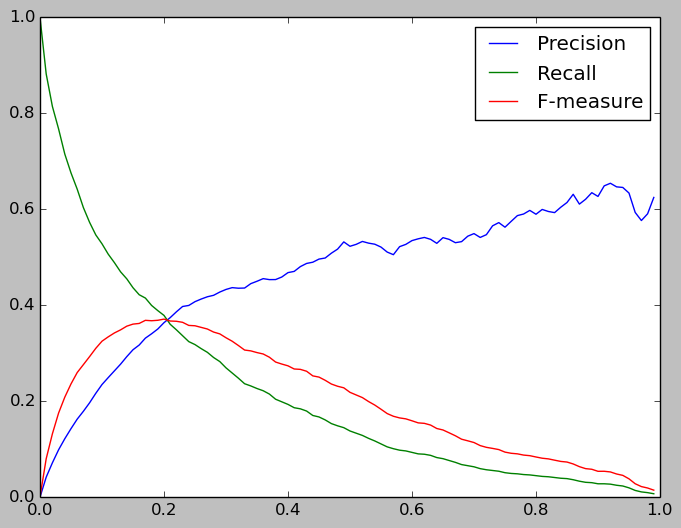

In [23]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print precisions[0], fmeasures[0]
assert (abs(precisions[0] - 0.000532546802671) < 0.0000001)
assert (abs(fmeasures[0] - 0.00106452669505) < 0.0000001)


fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass

## Lab3 quiz :  Part (5c) Line Plots - part 2 

If false-positives are considered much worse than false-negatives, how does that change your answer?

falsepos 比 falseNeg重要的多，所以考虑增大公式中falsePos的系数，看看对F-fueatre的影响。

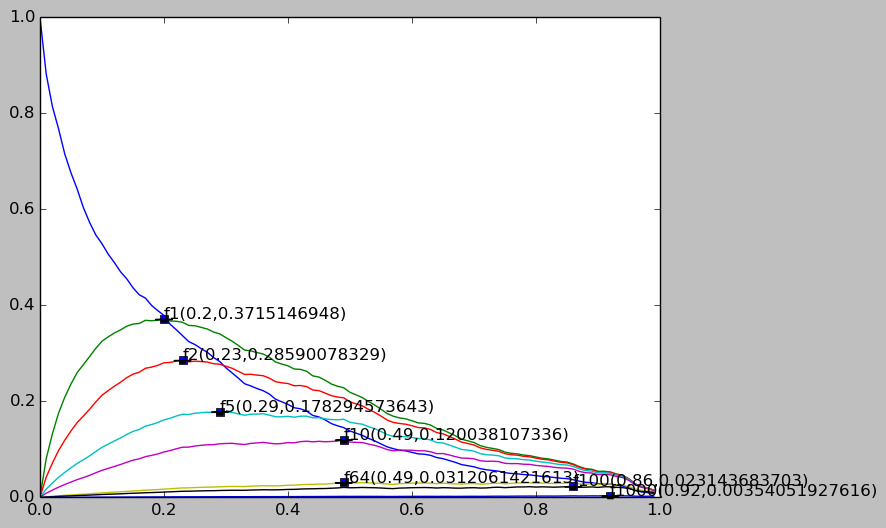

In [72]:
def precision_factor(threshold, factor):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold] * factor)

def fmeasure_factor(threshold, factor):
    r = recall(threshold)
    p = precision_factor(threshold,factor)
    return 2 * r * p / (r + p)

flist = [1,2, 5, 10, 64, 100, 1000]

fig = plt.figure()
plt.plot(thresholds, recalls)

for f in flist:
    # m = [precision_factor(t, f) for t in thresholds]
    m = [fmeasure_factor(t, f) for t in thresholds]

    plt.plot(thresholds, m)

    y = max(m)
    x = m.index(y)/100.0
    plt.plot(x, y, 'bs')
    text = 'f'+str(f)+'('+str(x)+','+str(y)+')'
    plt.annotate(text , xy=(x,y), xytext=(x, y), arrowprops=dict(facecolor='black', shrink=0.05))
             
pass

相同factor的三条曲线都是相交的，但是和最高点有差别。

## Discussion

In [ ]:
falsePosRDD = (simsFullRDD
          .leftOuterJoin(goldStandard)
          .filter(lambda record: record[1][0] >=0.2 and record[1][1] is None)
          )

print falsePosRDD.top(1)

falseNegRDD = (simsFullRDD
          .leftOuterJoin(goldStandard)
          .filter(lambda record: record[1][0] <0.2 and record[1][1] is None)
          )
print falseNegRDD.top(1)

In [80]:

print amazon.filter(lambda (k,v): k=='b000v9yxj4').top(1)
print google.filter(lambda (k,v): k=='http://www.google.com/base/feeds/snippets/17383951289144054339').top(1)


print amazon.filter(lambda (k,v): k=='b000v9yxj4').top(1)
print google.filter(lambda (k,v): k=='http://www.google.com/base/feeds/snippets/9852496278444342781').top(1)

[('b000v9yxj4', 'nero 8 ultra edition  "nero inc."')]
[('http://www.google.com/base/feeds/snippets/17383951289144054339', 'ahead software 70009 - nero nero v.7.0 ultra edition -enhanced - complete product - media management/conversion - 1 user - complete product - standard - pc "ahead software 70009 : nero 7 ultra edition enhanced now offers both the pc and tv media management experience for a complete solution. with over 18 new and updated applications in one powerful piece of software nero 7 ultra edition is truly the ..." ')]
[('b000v9yxj4', 'nero 8 ultra edition  "nero inc."')]
[('http://www.google.com/base/feeds/snippets/9852496278444342781', 'encore software 11180 - monopoly here & now - win 98 me 2000 xp "encore software 11180 : this special anniversary edition celebrates 70 years of the world s most popular board game with a modern day equivalent to the traditional game. system requirements: operating system: windows(r) 98/me/xp processor: pentium(r ..." ')]
